In [1]:
import h5py,pandas as pd, numpy as np
import os.path
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from tensorflow import keras
from tensorflow.keras import layers
import itertools
import matplotlib.pyplot as plt

Aquisition des données pour utilisation dans Jupyter (local)

In [3]:
from data import dataread, datatreat_A1
from models import cnn_1, cnn_4, cnn_5
from test import test_1
from tools import save_model, save_results, plot_loss_acc_history

In [4]:
X, y, X_final = dataread()

In [5]:
X_train, X_test, y_train, y_test, prop_HF = datatreat_A1(X, y, train_size=0.8, Shuffle=True, preprocess=None, ratio="50/50", balancing_method="rem/SMOTE")

La proportion H/F des données d'entraînement est de 1.0
L'échantillon de training comporte 27040 frames


In [7]:
epochs=150
batch_size=70
validation_split=0.1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 500, 100)       1000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 250, 100)       0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 250, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 250, 100)       90100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 125, 100)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 125, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 125, 300)       1

348/348 [==============================] - 25s 71ms/step - loss: 0.0874 - accuracy: 0.9698 - AUC: 0.9950 - val_loss: 1.3497 - val_accuracy: 0.6934 - val_AUC: 0.7502
Epoch 33/150
348/348 [==============================] - 25s 71ms/step - loss: 0.0549 - accuracy: 0.9818 - AUC: 0.9975 - val_loss: 1.6652 - val_accuracy: 0.7093 - val_AUC: 0.7501
Epoch 34/150
348/348 [==============================] - 25s 72ms/step - loss: 0.0515 - accuracy: 0.9837 - AUC: 0.9977 - val_loss: 1.6972 - val_accuracy: 0.6886 - val_AUC: 0.7453
Epoch 35/150
348/348 [==============================] - 25s 72ms/step - loss: 0.0308 - accuracy: 0.9905 - AUC: 0.9992 - val_loss: 1.7765 - val_accuracy: 0.6834 - val_AUC: 0.7413
Epoch 36/150
348/348 [==============================] - 25s 71ms/step - loss: 0.0313 - accuracy: 0.9911 - AUC: 0.9989 - val_loss: 1.7956 - val_accuracy: 0.6808 - val_AUC: 0.7399
Epoch 37/150
348/348 [==============================] - 25s 71ms/step - loss: 0.0296 - accuracy: 0.9917 - AUC: 0.9992 - val

348/348 [==============================] - 25s 72ms/step - loss: 0.0089 - accuracy: 0.9977 - AUC: 0.9996 - val_loss: 3.0835 - val_accuracy: 0.7075 - val_AUC: 0.7382
Epoch 78/150
348/348 [==============================] - 25s 71ms/step - loss: 0.0034 - accuracy: 0.9990 - AUC: 0.9999 - val_loss: 2.9366 - val_accuracy: 0.7067 - val_AUC: 0.7366
Epoch 79/150
348/348 [==============================] - 25s 71ms/step - loss: 0.0067 - accuracy: 0.9985 - AUC: 0.9998 - val_loss: 2.6544 - val_accuracy: 0.6890 - val_AUC: 0.7298
Epoch 80/150
348/348 [==============================] - 25s 72ms/step - loss: 0.0038 - accuracy: 0.9989 - AUC: 0.9999 - val_loss: 3.0472 - val_accuracy: 0.7093 - val_AUC: 0.7415
Epoch 81/150
348/348 [==============================] - 25s 73ms/step - loss: 0.0025 - accuracy: 0.9994 - AUC: 0.9999 - val_loss: 2.8226 - val_accuracy: 0.6897 - val_AUC: 0.7378
Epoch 82/150
348/348 [==============================] - 25s 72ms/step - loss: 0.0032 - accuracy: 0.9988 - AUC: 1.0000 - val

348/348 [==============================] - 25s 71ms/step - loss: 7.5120e-04 - accuracy: 0.9999 - AUC: 1.0000 - val_loss: 4.0659 - val_accuracy: 0.7041 - val_AUC: 0.7284
Epoch 123/150
348/348 [==============================] - 25s 71ms/step - loss: 0.0059 - accuracy: 0.9981 - AUC: 0.9998 - val_loss: 3.3893 - val_accuracy: 0.6790 - val_AUC: 0.7168
Epoch 124/150
348/348 [==============================] - 25s 71ms/step - loss: 0.0027 - accuracy: 0.9994 - AUC: 0.9999 - val_loss: 3.3081 - val_accuracy: 0.6953 - val_AUC: 0.7237
Epoch 125/150
348/348 [==============================] - 25s 71ms/step - loss: 0.0042 - accuracy: 0.9987 - AUC: 0.9998 - val_loss: 3.7789 - val_accuracy: 0.7030 - val_AUC: 0.7334
Epoch 126/150
348/348 [==============================] - 25s 72ms/step - loss: 0.0018 - accuracy: 0.9995 - AUC: 1.0000 - val_loss: 3.7541 - val_accuracy: 0.7001 - val_AUC: 0.7346
Epoch 127/150
348/348 [==============================] - 25s 72ms/step - loss: 0.0051 - accuracy: 0.9985 - AUC: 0.9

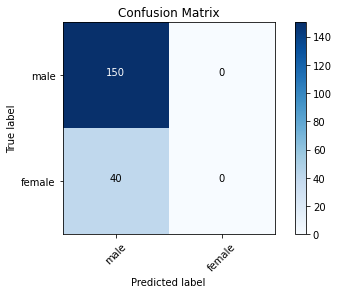

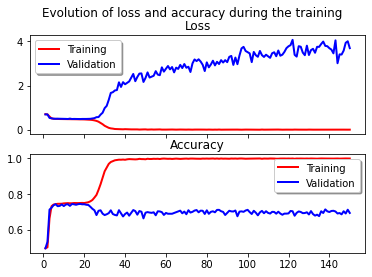

In [8]:
id='cnn_1_None_remSMOTE'
model = cnn_1()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 None rem/SMOTE', 'cnn_1', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 7, 500, 25)        275       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 500, 25)        4375      
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 500, 25)        100       
_________________________________________________________________
activation (Activation)      (None, 7, 500, 25)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 167, 25)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 167, 25)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 167, 50)       

Epoch 29/150
348/348 [==============================] - 15s 43ms/step - loss: 0.4406 - accuracy: 0.7727 - AUC: 0.8504 - val_loss: 0.4858 - val_accuracy: 0.7452 - val_AUC: 0.8127
Epoch 30/150
348/348 [==============================] - 15s 43ms/step - loss: 0.4421 - accuracy: 0.7735 - AUC: 0.8492 - val_loss: 0.4790 - val_accuracy: 0.7485 - val_AUC: 0.8162
Epoch 31/150
348/348 [==============================] - 15s 44ms/step - loss: 0.4321 - accuracy: 0.7769 - AUC: 0.8571 - val_loss: 0.4991 - val_accuracy: 0.7223 - val_AUC: 0.8123
Epoch 32/150
348/348 [==============================] - 15s 43ms/step - loss: 0.4289 - accuracy: 0.7784 - AUC: 0.8607 - val_loss: 0.4903 - val_accuracy: 0.7433 - val_AUC: 0.8156
Epoch 33/150
348/348 [==============================] - 16s 45ms/step - loss: 0.4269 - accuracy: 0.7827 - AUC: 0.8619 - val_loss: 0.4901 - val_accuracy: 0.7293 - val_AUC: 0.8168
Epoch 34/150
348/348 [==============================] - 15s 43ms/step - loss: 0.4223 - accuracy: 0.7869 - AUC:

348/348 [==============================] - 15s 43ms/step - loss: 0.2387 - accuracy: 0.8958 - AUC: 0.9641 - val_loss: 0.6882 - val_accuracy: 0.7119 - val_AUC: 0.7880
Epoch 76/150
348/348 [==============================] - 15s 43ms/step - loss: 0.2397 - accuracy: 0.8952 - AUC: 0.9632 - val_loss: 0.6623 - val_accuracy: 0.7012 - val_AUC: 0.7929
Epoch 77/150
348/348 [==============================] - 15s 43ms/step - loss: 0.2354 - accuracy: 0.8971 - AUC: 0.9649 - val_loss: 0.6900 - val_accuracy: 0.7067 - val_AUC: 0.7902
Epoch 78/150
348/348 [==============================] - 15s 43ms/step - loss: 0.2345 - accuracy: 0.8972 - AUC: 0.9652 - val_loss: 0.6749 - val_accuracy: 0.7056 - val_AUC: 0.7899
Epoch 79/150
348/348 [==============================] - 15s 43ms/step - loss: 0.2285 - accuracy: 0.8995 - AUC: 0.9670 - val_loss: 0.7049 - val_accuracy: 0.7138 - val_AUC: 0.7907
Epoch 80/150
348/348 [==============================] - 15s 43ms/step - loss: 0.2268 - accuracy: 0.9026 - AUC: 0.9678 - val

Epoch 121/150
348/348 [==============================] - 15s 43ms/step - loss: 0.1529 - accuracy: 0.9372 - AUC: 0.9856 - val_loss: 0.8425 - val_accuracy: 0.7001 - val_AUC: 0.7850
Epoch 122/150
348/348 [==============================] - 15s 43ms/step - loss: 0.1481 - accuracy: 0.9401 - AUC: 0.9864 - val_loss: 0.8531 - val_accuracy: 0.6964 - val_AUC: 0.7759
Epoch 123/150
348/348 [==============================] - 15s 43ms/step - loss: 0.1496 - accuracy: 0.9387 - AUC: 0.9860 - val_loss: 0.9117 - val_accuracy: 0.6956 - val_AUC: 0.7757
Epoch 124/150
348/348 [==============================] - 15s 43ms/step - loss: 0.1413 - accuracy: 0.9438 - AUC: 0.9875 - val_loss: 0.8941 - val_accuracy: 0.7078 - val_AUC: 0.7821
Epoch 125/150
348/348 [==============================] - 15s 43ms/step - loss: 0.1472 - accuracy: 0.9405 - AUC: 0.9865 - val_loss: 0.9105 - val_accuracy: 0.6967 - val_AUC: 0.7746
Epoch 126/150
348/348 [==============================] - 15s 43ms/step - loss: 0.1412 - accuracy: 0.9449 

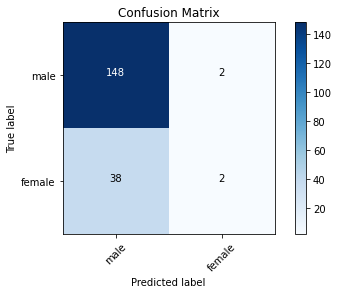

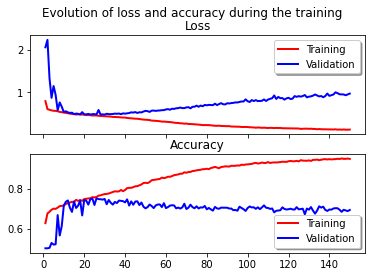

In [9]:
id='cnn_4_None_remSMOTE'
model = cnn_4()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 None rem/SMOTE', 'cnn_4', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 7, 500, 40)        1040      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 500, 40)        11200     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 500, 40)        160       
_________________________________________________________________
activation_4 (Activation)    (None, 7, 500, 40)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 7, 34, 40)         0         
_________________________________________________________________
activation_5 (Activation)    (None, 7, 34, 40)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9520)             

348/348 [==============================] - 14s 41ms/step - loss: 0.3680 - accuracy: 0.8230 - AUC: 0.9080 - val_loss: 0.5980 - val_accuracy: 0.7171 - val_AUC: 0.7911
Epoch 40/150
348/348 [==============================] - 14s 41ms/step - loss: 0.3754 - accuracy: 0.8202 - AUC: 0.9046 - val_loss: 0.6183 - val_accuracy: 0.7371 - val_AUC: 0.7956
Epoch 41/150
348/348 [==============================] - 14s 41ms/step - loss: 0.3618 - accuracy: 0.8260 - AUC: 0.9113 - val_loss: 0.6273 - val_accuracy: 0.7167 - val_AUC: 0.7906
Epoch 42/150
348/348 [==============================] - 14s 41ms/step - loss: 0.3626 - accuracy: 0.8239 - AUC: 0.9107 - val_loss: 0.6197 - val_accuracy: 0.7008 - val_AUC: 0.7898
Epoch 43/150
348/348 [==============================] - 14s 41ms/step - loss: 0.3452 - accuracy: 0.8332 - AUC: 0.9194 - val_loss: 0.6454 - val_accuracy: 0.6797 - val_AUC: 0.7999
Epoch 44/150
348/348 [==============================] - 14s 41ms/step - loss: 0.3592 - accuracy: 0.8290 - AUC: 0.9132 - val

348/348 [==============================] - 14s 41ms/step - loss: 0.2793 - accuracy: 0.8724 - AUC: 0.9501 - val_loss: 0.6895 - val_accuracy: 0.7152 - val_AUC: 0.7923
Epoch 86/150
348/348 [==============================] - 14s 40ms/step - loss: 0.2877 - accuracy: 0.8670 - AUC: 0.9465 - val_loss: 0.7141 - val_accuracy: 0.7130 - val_AUC: 0.7945
Epoch 87/150
348/348 [==============================] - 14s 40ms/step - loss: 0.2908 - accuracy: 0.8642 - AUC: 0.9451 - val_loss: 0.7177 - val_accuracy: 0.7086 - val_AUC: 0.7904
Epoch 88/150
348/348 [==============================] - 14s 40ms/step - loss: 0.2882 - accuracy: 0.8696 - AUC: 0.9464 - val_loss: 0.7096 - val_accuracy: 0.6997 - val_AUC: 0.7879
Epoch 89/150
348/348 [==============================] - 14s 41ms/step - loss: 0.2787 - accuracy: 0.8735 - AUC: 0.9498 - val_loss: 0.6968 - val_accuracy: 0.7008 - val_AUC: 0.7913
Epoch 90/150
348/348 [==============================] - 14s 41ms/step - loss: 0.2792 - accuracy: 0.8740 - AUC: 0.9494 - val

Epoch 131/150
348/348 [==============================] - 14s 40ms/step - loss: 0.2366 - accuracy: 0.8957 - AUC: 0.9651 - val_loss: 0.7808 - val_accuracy: 0.7089 - val_AUC: 0.7902
Epoch 132/150
348/348 [==============================] - 14s 40ms/step - loss: 0.2436 - accuracy: 0.8946 - AUC: 0.9626 - val_loss: 0.8118 - val_accuracy: 0.6956 - val_AUC: 0.7847
Epoch 133/150
348/348 [==============================] - 14s 40ms/step - loss: 0.2407 - accuracy: 0.8913 - AUC: 0.9634 - val_loss: 0.8210 - val_accuracy: 0.6930 - val_AUC: 0.7860
Epoch 134/150
348/348 [==============================] - 14s 40ms/step - loss: 0.2429 - accuracy: 0.8933 - AUC: 0.9626 - val_loss: 0.8078 - val_accuracy: 0.7053 - val_AUC: 0.7854
Epoch 135/150
348/348 [==============================] - 14s 41ms/step - loss: 0.2421 - accuracy: 0.8937 - AUC: 0.9631 - val_loss: 0.8032 - val_accuracy: 0.6982 - val_AUC: 0.7844
Epoch 136/150
348/348 [==============================] - 14s 41ms/step - loss: 0.2441 - accuracy: 0.8896 

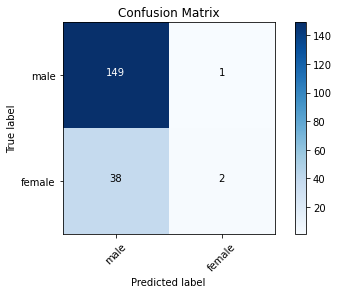

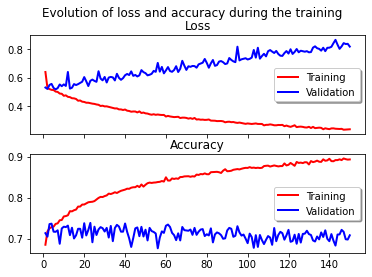

In [10]:
id='cnn_5_None_remSMOTE'
model = cnn_5()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 None rem/SMOTE', 'cnn_5', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)

In [11]:
X_train, X_test, y_train, y_test, prop_HF = datatreat_A1(X, y, train_size=0.8, Shuffle=True, preprocess="Normalization", ratio="50/50", balancing_method="rem/SMOTE")

La proportion H/F des données d'entraînement est de 1.0
L'échantillon de training comporte 26400 frames


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 7, 500, 100)       1000      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 250, 100)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 250, 100)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 250, 100)       90100     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 125, 100)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 125, 100)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 2, 125, 300)      

340/340 [==============================] - 25s 73ms/step - loss: 0.0414 - accuracy: 0.9872 - AUC: 0.9984 - val_loss: 1.6058 - val_accuracy: 0.6803 - val_AUC: 0.7512
Epoch 33/150
340/340 [==============================] - 25s 73ms/step - loss: 0.0359 - accuracy: 0.9885 - AUC: 0.9988 - val_loss: 1.5747 - val_accuracy: 0.6860 - val_AUC: 0.7569
Epoch 34/150
340/340 [==============================] - 25s 73ms/step - loss: 0.0279 - accuracy: 0.9922 - AUC: 0.9993 - val_loss: 1.4563 - val_accuracy: 0.7095 - val_AUC: 0.7637
Epoch 35/150
340/340 [==============================] - 25s 73ms/step - loss: 0.0204 - accuracy: 0.9933 - AUC: 0.9996 - val_loss: 1.7260 - val_accuracy: 0.7027 - val_AUC: 0.7528
Epoch 36/150
340/340 [==============================] - 25s 73ms/step - loss: 0.0208 - accuracy: 0.9944 - AUC: 0.9994 - val_loss: 1.8187 - val_accuracy: 0.6981 - val_AUC: 0.7533
Epoch 37/150
340/340 [==============================] - 25s 73ms/step - loss: 0.0153 - accuracy: 0.9947 - AUC: 0.9998 - val

340/340 [==============================] - 24s 72ms/step - loss: 0.0064 - accuracy: 0.9983 - AUC: 0.9998 - val_loss: 2.6868 - val_accuracy: 0.7083 - val_AUC: 0.7396
Epoch 79/150
340/340 [==============================] - 25s 73ms/step - loss: 0.0056 - accuracy: 0.9981 - AUC: 0.9999 - val_loss: 2.5779 - val_accuracy: 0.6989 - val_AUC: 0.7459
Epoch 80/150
340/340 [==============================] - 25s 72ms/step - loss: 0.0061 - accuracy: 0.9982 - AUC: 0.9998 - val_loss: 2.6284 - val_accuracy: 0.7068 - val_AUC: 0.7449
Epoch 81/150
340/340 [==============================] - 25s 72ms/step - loss: 0.0024 - accuracy: 0.9994 - AUC: 1.0000 - val_loss: 2.7074 - val_accuracy: 0.6970 - val_AUC: 0.7433
Epoch 82/150
340/340 [==============================] - 25s 72ms/step - loss: 0.0034 - accuracy: 0.9990 - AUC: 0.9999 - val_loss: 2.8176 - val_accuracy: 0.7030 - val_AUC: 0.7440
Epoch 83/150
340/340 [==============================] - 25s 73ms/step - loss: 0.0039 - accuracy: 0.9987 - AUC: 0.9998 - val

340/340 [==============================] - 25s 72ms/step - loss: 0.0013 - accuracy: 0.9996 - AUC: 1.0000 - val_loss: 3.1625 - val_accuracy: 0.7148 - val_AUC: 0.7464
Epoch 124/150
340/340 [==============================] - 24s 72ms/step - loss: 0.0042 - accuracy: 0.9991 - AUC: 0.9997 - val_loss: 3.1416 - val_accuracy: 0.7027 - val_AUC: 0.7394
Epoch 125/150
340/340 [==============================] - 25s 72ms/step - loss: 0.0020 - accuracy: 0.9994 - AUC: 1.0000 - val_loss: 2.9824 - val_accuracy: 0.6894 - val_AUC: 0.7260
Epoch 126/150
340/340 [==============================] - 25s 72ms/step - loss: 0.0088 - accuracy: 0.9980 - AUC: 0.9994 - val_loss: 3.1177 - val_accuracy: 0.7072 - val_AUC: 0.7437
Epoch 127/150
340/340 [==============================] - 25s 72ms/step - loss: 0.0015 - accuracy: 0.9994 - AUC: 1.0000 - val_loss: 3.4228 - val_accuracy: 0.6981 - val_AUC: 0.7352
Epoch 128/150
340/340 [==============================] - 25s 72ms/step - loss: 0.0102 - accuracy: 0.9976 - AUC: 0.9995 

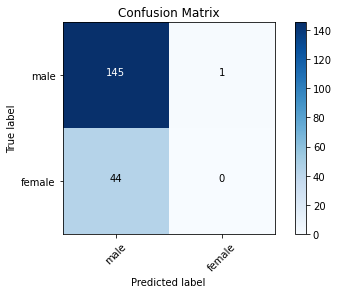

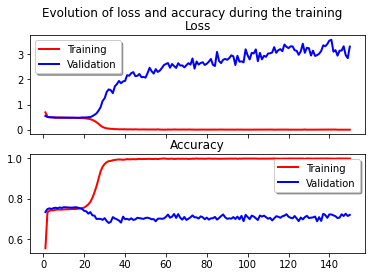

In [12]:
id='cnn_1_normalized_remSMOTE'
model = cnn_1()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 Normalization rem/SMOTE', 'cnn_1', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 7, 500, 25)        275       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 500, 25)        4375      
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 500, 25)        100       
_________________________________________________________________
activation_6 (Activation)    (None, 7, 500, 25)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 167, 25)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 167, 25)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 167, 50)       

Epoch 29/150
340/340 [==============================] - 15s 44ms/step - loss: 0.4632 - accuracy: 0.7532 - AUC: 0.8231 - val_loss: 0.5149 - val_accuracy: 0.6939 - val_AUC: 0.7911
Epoch 30/150
340/340 [==============================] - 15s 44ms/step - loss: 0.4550 - accuracy: 0.7603 - AUC: 0.8330 - val_loss: 0.4919 - val_accuracy: 0.7527 - val_AUC: 0.7937
Epoch 31/150
340/340 [==============================] - 15s 44ms/step - loss: 0.4523 - accuracy: 0.7669 - AUC: 0.8361 - val_loss: 0.4858 - val_accuracy: 0.7515 - val_AUC: 0.7841
Epoch 32/150
340/340 [==============================] - 15s 44ms/step - loss: 0.4514 - accuracy: 0.7637 - AUC: 0.8374 - val_loss: 0.5392 - val_accuracy: 0.7523 - val_AUC: 0.7881
Epoch 33/150
340/340 [==============================] - 15s 44ms/step - loss: 0.4495 - accuracy: 0.7626 - AUC: 0.8396 - val_loss: 0.4857 - val_accuracy: 0.7470 - val_AUC: 0.7907
Epoch 34/150
340/340 [==============================] - 15s 44ms/step - loss: 0.4473 - accuracy: 0.7654 - AUC:

340/340 [==============================] - 15s 44ms/step - loss: 0.2954 - accuracy: 0.8651 - AUC: 0.9434 - val_loss: 0.6144 - val_accuracy: 0.7008 - val_AUC: 0.7871
Epoch 76/150
340/340 [==============================] - 15s 43ms/step - loss: 0.2917 - accuracy: 0.8691 - AUC: 0.9449 - val_loss: 0.6087 - val_accuracy: 0.7121 - val_AUC: 0.7885
Epoch 77/150
340/340 [==============================] - 15s 43ms/step - loss: 0.2905 - accuracy: 0.8682 - AUC: 0.9452 - val_loss: 0.6088 - val_accuracy: 0.7027 - val_AUC: 0.7870
Epoch 78/150
340/340 [==============================] - 15s 43ms/step - loss: 0.2790 - accuracy: 0.8701 - AUC: 0.9498 - val_loss: 0.6140 - val_accuracy: 0.6973 - val_AUC: 0.7854
Epoch 79/150
340/340 [==============================] - 15s 43ms/step - loss: 0.2812 - accuracy: 0.8710 - AUC: 0.9486 - val_loss: 0.6368 - val_accuracy: 0.7178 - val_AUC: 0.7822
Epoch 80/150
340/340 [==============================] - 15s 43ms/step - loss: 0.2772 - accuracy: 0.8759 - AUC: 0.9507 - val

Epoch 121/150
340/340 [==============================] - 15s 43ms/step - loss: 0.1853 - accuracy: 0.9211 - AUC: 0.9787 - val_loss: 0.7808 - val_accuracy: 0.7091 - val_AUC: 0.7796
Epoch 122/150
340/340 [==============================] - 15s 43ms/step - loss: 0.1831 - accuracy: 0.9212 - AUC: 0.9789 - val_loss: 0.8030 - val_accuracy: 0.6928 - val_AUC: 0.7812
Epoch 123/150
340/340 [==============================] - 15s 43ms/step - loss: 0.1781 - accuracy: 0.9264 - AUC: 0.9802 - val_loss: 0.8493 - val_accuracy: 0.6795 - val_AUC: 0.7780
Epoch 124/150
340/340 [==============================] - 15s 43ms/step - loss: 0.1809 - accuracy: 0.9235 - AUC: 0.9796 - val_loss: 0.7936 - val_accuracy: 0.6962 - val_AUC: 0.7807
Epoch 125/150
340/340 [==============================] - 15s 43ms/step - loss: 0.1760 - accuracy: 0.9256 - AUC: 0.9811 - val_loss: 0.7848 - val_accuracy: 0.7049 - val_AUC: 0.7810
Epoch 126/150
340/340 [==============================] - 15s 43ms/step - loss: 0.1808 - accuracy: 0.9246 

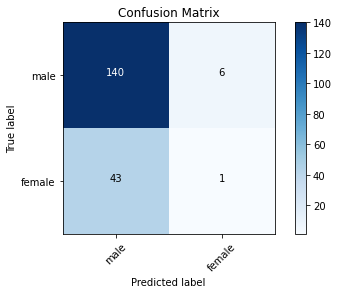

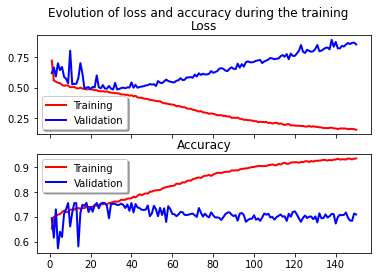

In [13]:
id='cnn_4_normalized_remSMOTE'
model = cnn_4()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 Normalization rem/SMOTE', 'cnn_4', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 7, 500, 40)        1040      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 500, 40)        11200     
_________________________________________________________________
batch_normalization_9 (Batch (None, 7, 500, 40)        160       
_________________________________________________________________
activation_10 (Activation)   (None, 7, 500, 40)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 34, 40)         0         
_________________________________________________________________
activation_11 (Activation)   (None, 7, 34, 40)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9520)             

340/340 [==============================] - 14s 41ms/step - loss: 0.3641 - accuracy: 0.8242 - AUC: 0.9087 - val_loss: 0.6114 - val_accuracy: 0.7201 - val_AUC: 0.7820
Epoch 40/150
340/340 [==============================] - 14s 41ms/step - loss: 0.3762 - accuracy: 0.8158 - AUC: 0.9031 - val_loss: 0.6199 - val_accuracy: 0.7080 - val_AUC: 0.7832
Epoch 41/150
340/340 [==============================] - 14s 41ms/step - loss: 0.3724 - accuracy: 0.8164 - AUC: 0.9042 - val_loss: 0.6217 - val_accuracy: 0.7284 - val_AUC: 0.7820
Epoch 42/150
340/340 [==============================] - 14s 41ms/step - loss: 0.3657 - accuracy: 0.8229 - AUC: 0.9085 - val_loss: 0.6687 - val_accuracy: 0.6686 - val_AUC: 0.7734
Epoch 43/150
340/340 [==============================] - 14s 42ms/step - loss: 0.3756 - accuracy: 0.8152 - AUC: 0.9035 - val_loss: 0.6571 - val_accuracy: 0.6985 - val_AUC: 0.7662
Epoch 44/150
340/340 [==============================] - 14s 41ms/step - loss: 0.3715 - accuracy: 0.8205 - AUC: 0.9059 - val

340/340 [==============================] - 14s 41ms/step - loss: 0.3033 - accuracy: 0.8609 - AUC: 0.9395 - val_loss: 0.7239 - val_accuracy: 0.7057 - val_AUC: 0.7814
Epoch 86/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2983 - accuracy: 0.8591 - AUC: 0.9411 - val_loss: 0.7319 - val_accuracy: 0.6936 - val_AUC: 0.7739
Epoch 87/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2984 - accuracy: 0.8622 - AUC: 0.9413 - val_loss: 0.7501 - val_accuracy: 0.7004 - val_AUC: 0.7718
Epoch 88/150
340/340 [==============================] - 14s 41ms/step - loss: 0.3099 - accuracy: 0.8579 - AUC: 0.9369 - val_loss: 0.7728 - val_accuracy: 0.6750 - val_AUC: 0.7716
Epoch 89/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2945 - accuracy: 0.8680 - AUC: 0.9437 - val_loss: 0.7167 - val_accuracy: 0.7042 - val_AUC: 0.7758
Epoch 90/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2926 - accuracy: 0.8669 - AUC: 0.9440 - val

Epoch 131/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2616 - accuracy: 0.8809 - AUC: 0.9566 - val_loss: 0.8384 - val_accuracy: 0.7061 - val_AUC: 0.7747
Epoch 132/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2569 - accuracy: 0.8837 - AUC: 0.9582 - val_loss: 0.8326 - val_accuracy: 0.7015 - val_AUC: 0.7740
Epoch 133/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2471 - accuracy: 0.8906 - AUC: 0.9613 - val_loss: 0.8276 - val_accuracy: 0.6985 - val_AUC: 0.7754
Epoch 134/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2530 - accuracy: 0.8866 - AUC: 0.9593 - val_loss: 0.8311 - val_accuracy: 0.7019 - val_AUC: 0.7733
Epoch 135/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2544 - accuracy: 0.8849 - AUC: 0.9587 - val_loss: 0.8740 - val_accuracy: 0.6583 - val_AUC: 0.7674
Epoch 136/150
340/340 [==============================] - 14s 41ms/step - loss: 0.2522 - accuracy: 0.8874 

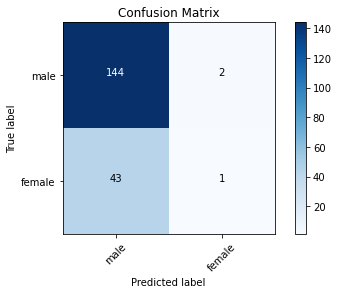

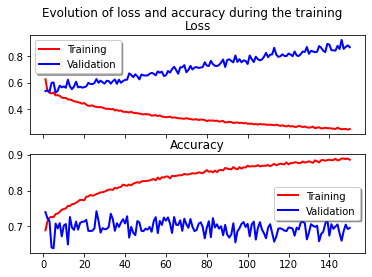

In [14]:
id='cnn_5_normalized_remSMOTE'
model = cnn_5()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 Normalization rem/SMOTE', 'cnn_5', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)

In [15]:
X_train, X_test, y_train, y_test, prop_HF = datatreat_A1(X, y, train_size=0.8, Shuffle=True, preprocess="Standardization", ratio="50/50", balancing_method="rem/SMOTE")

La proportion H/F des données d'entraînement est de 1.0
L'échantillon de training comporte 27520 frames


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 7, 500, 100)       1000      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 250, 100)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 4, 250, 100)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 4, 250, 100)       90100     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 125, 100)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 2, 125, 100)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 2, 125, 300)      

354/354 [==============================] - 25s 72ms/step - loss: 0.0170 - accuracy: 0.9946 - AUC: 0.9995 - val_loss: 1.8072 - val_accuracy: 0.6860 - val_AUC: 0.7435
Epoch 33/150
354/354 [==============================] - 25s 71ms/step - loss: 0.0111 - accuracy: 0.9960 - AUC: 0.9999 - val_loss: 1.9557 - val_accuracy: 0.7017 - val_AUC: 0.7429
Epoch 34/150
354/354 [==============================] - 25s 71ms/step - loss: 0.0155 - accuracy: 0.9954 - AUC: 0.9997 - val_loss: 1.7545 - val_accuracy: 0.6926 - val_AUC: 0.7450
Epoch 35/150
354/354 [==============================] - 25s 71ms/step - loss: 0.0151 - accuracy: 0.9945 - AUC: 0.9997 - val_loss: 1.8517 - val_accuracy: 0.6860 - val_AUC: 0.7389
Epoch 36/150
354/354 [==============================] - 25s 71ms/step - loss: 0.0113 - accuracy: 0.9970 - AUC: 0.9997 - val_loss: 2.0891 - val_accuracy: 0.7020 - val_AUC: 0.7414
Epoch 37/150
354/354 [==============================] - 25s 71ms/step - loss: 0.0114 - accuracy: 0.9965 - AUC: 0.9996 - val

354/354 [==============================] - 25s 72ms/step - loss: 0.0059 - accuracy: 0.9983 - AUC: 0.9998 - val_loss: 2.9200 - val_accuracy: 0.6940 - val_AUC: 0.7262
Epoch 79/150
354/354 [==============================] - 25s 72ms/step - loss: 0.0023 - accuracy: 0.9993 - AUC: 0.9999 - val_loss: 3.0906 - val_accuracy: 0.6991 - val_AUC: 0.7231
Epoch 80/150
354/354 [==============================] - 26s 72ms/step - loss: 0.0030 - accuracy: 0.9987 - AUC: 1.0000 - val_loss: 2.8181 - val_accuracy: 0.6828 - val_AUC: 0.7162
Epoch 81/150
354/354 [==============================] - 26s 72ms/step - loss: 0.0039 - accuracy: 0.9993 - AUC: 0.9998 - val_loss: 3.0828 - val_accuracy: 0.7028 - val_AUC: 0.7369
Epoch 82/150
354/354 [==============================] - 25s 72ms/step - loss: 0.0072 - accuracy: 0.9985 - AUC: 0.9996 - val_loss: 2.7435 - val_accuracy: 0.6977 - val_AUC: 0.7346
Epoch 83/150
354/354 [==============================] - 25s 72ms/step - loss: 0.0023 - accuracy: 0.9989 - AUC: 1.0000 - val

Epoch 124/150
354/354 [==============================] - 26s 73ms/step - loss: 0.0058 - accuracy: 0.9989 - AUC: 0.9995 - val_loss: 3.3599 - val_accuracy: 0.7042 - val_AUC: 0.7350
Epoch 125/150
354/354 [==============================] - 26s 73ms/step - loss: 0.0025 - accuracy: 0.9994 - AUC: 0.9999 - val_loss: 3.2577 - val_accuracy: 0.7009 - val_AUC: 0.7315
Epoch 126/150
354/354 [==============================] - 26s 73ms/step - loss: 0.0014 - accuracy: 0.9997 - AUC: 0.9999 - val_loss: 2.8711 - val_accuracy: 0.6879 - val_AUC: 0.7294
Epoch 127/150
354/354 [==============================] - 26s 73ms/step - loss: 0.0034 - accuracy: 0.9988 - AUC: 0.9999 - val_loss: 3.3923 - val_accuracy: 0.6904 - val_AUC: 0.7265
Epoch 128/150
354/354 [==============================] - 26s 73ms/step - loss: 0.0031 - accuracy: 0.9991 - AUC: 0.9999 - val_loss: 3.3610 - val_accuracy: 0.6966 - val_AUC: 0.7300
Epoch 129/150
354/354 [==============================] - 26s 73ms/step - loss: 0.0015 - accuracy: 0.9994 

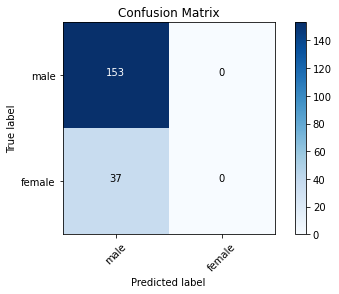

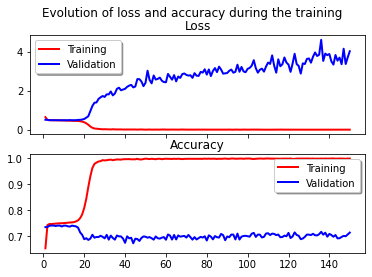

In [16]:
id='cnn_1_standardized_remSMOTE'
model = cnn_1()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 Standardization rem/SMOTE', 'cnn_1', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 7, 500, 25)        275       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 500, 25)        4375      
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 500, 25)        100       
_________________________________________________________________
activation_12 (Activation)   (None, 7, 500, 25)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 167, 25)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 7, 167, 25)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 167, 50)       

Epoch 29/150
354/354 [==============================] - 15s 44ms/step - loss: 0.4353 - accuracy: 0.7771 - AUC: 0.8584 - val_loss: 0.5096 - val_accuracy: 0.7053 - val_AUC: 0.7934
Epoch 30/150
354/354 [==============================] - 15s 44ms/step - loss: 0.4286 - accuracy: 0.7814 - AUC: 0.8637 - val_loss: 0.5155 - val_accuracy: 0.7064 - val_AUC: 0.7929
Epoch 31/150
354/354 [==============================] - 15s 43ms/step - loss: 0.4204 - accuracy: 0.7875 - AUC: 0.8680 - val_loss: 0.5027 - val_accuracy: 0.7086 - val_AUC: 0.7926
Epoch 32/150
354/354 [==============================] - 15s 43ms/step - loss: 0.4186 - accuracy: 0.7908 - AUC: 0.8707 - val_loss: 0.5259 - val_accuracy: 0.7326 - val_AUC: 0.7928
Epoch 33/150
354/354 [==============================] - 15s 44ms/step - loss: 0.4132 - accuracy: 0.7950 - AUC: 0.8759 - val_loss: 0.5187 - val_accuracy: 0.7042 - val_AUC: 0.7908
Epoch 34/150
354/354 [==============================] - 15s 43ms/step - loss: 0.4136 - accuracy: 0.7906 - AUC:

354/354 [==============================] - 15s 44ms/step - loss: 0.2752 - accuracy: 0.8788 - AUC: 0.9510 - val_loss: 0.6498 - val_accuracy: 0.7053 - val_AUC: 0.7799
Epoch 76/150
354/354 [==============================] - 15s 43ms/step - loss: 0.2837 - accuracy: 0.8723 - AUC: 0.9479 - val_loss: 0.6196 - val_accuracy: 0.6835 - val_AUC: 0.7839
Epoch 77/150
354/354 [==============================] - 15s 44ms/step - loss: 0.2787 - accuracy: 0.8741 - AUC: 0.9505 - val_loss: 0.6573 - val_accuracy: 0.6813 - val_AUC: 0.7829
Epoch 78/150
354/354 [==============================] - 15s 44ms/step - loss: 0.2806 - accuracy: 0.8719 - AUC: 0.9489 - val_loss: 0.6313 - val_accuracy: 0.6966 - val_AUC: 0.7827
Epoch 79/150
354/354 [==============================] - 15s 43ms/step - loss: 0.2752 - accuracy: 0.8772 - AUC: 0.9512 - val_loss: 0.6496 - val_accuracy: 0.6933 - val_AUC: 0.7790
Epoch 80/150
354/354 [==============================] - 15s 44ms/step - loss: 0.2743 - accuracy: 0.8752 - AUC: 0.9519 - val

Epoch 121/150
354/354 [==============================] - 15s 44ms/step - loss: 0.2029 - accuracy: 0.9127 - AUC: 0.9741 - val_loss: 0.7814 - val_accuracy: 0.6791 - val_AUC: 0.7792
Epoch 122/150
354/354 [==============================] - 15s 43ms/step - loss: 0.2081 - accuracy: 0.9095 - AUC: 0.9730 - val_loss: 0.7858 - val_accuracy: 0.6944 - val_AUC: 0.7764
Epoch 123/150
354/354 [==============================] - 15s 44ms/step - loss: 0.2032 - accuracy: 0.9159 - AUC: 0.9743 - val_loss: 0.7787 - val_accuracy: 0.6766 - val_AUC: 0.7763
Epoch 124/150
354/354 [==============================] - 15s 43ms/step - loss: 0.1997 - accuracy: 0.9131 - AUC: 0.9749 - val_loss: 0.7634 - val_accuracy: 0.6948 - val_AUC: 0.7823
Epoch 125/150
354/354 [==============================] - 15s 43ms/step - loss: 0.1991 - accuracy: 0.9153 - AUC: 0.9751 - val_loss: 0.7823 - val_accuracy: 0.6770 - val_AUC: 0.7717
Epoch 126/150
354/354 [==============================] - 15s 43ms/step - loss: 0.1969 - accuracy: 0.9158 

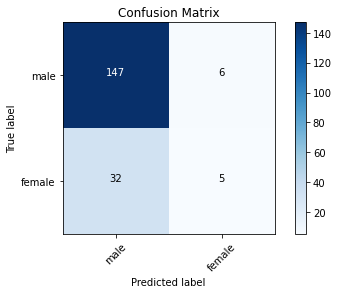

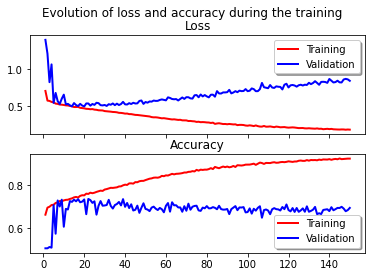

In [17]:
id='cnn_4_standardized_remSMOTE'
model = cnn_4()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 Standardization rem/SMOTE', 'cnn_4', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 7, 500, 40)        1040      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 7, 500, 40)        11200     
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 500, 40)        160       
_________________________________________________________________
activation_16 (Activation)   (None, 7, 500, 40)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 7, 34, 40)         0         
_________________________________________________________________
activation_17 (Activation)   (None, 7, 34, 40)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 9520)             

354/354 [==============================] - 15s 42ms/step - loss: 0.3481 - accuracy: 0.8357 - AUC: 0.9176 - val_loss: 0.7286 - val_accuracy: 0.6857 - val_AUC: 0.7698
Epoch 40/150
354/354 [==============================] - 15s 42ms/step - loss: 0.3578 - accuracy: 0.8327 - AUC: 0.9138 - val_loss: 0.7074 - val_accuracy: 0.6642 - val_AUC: 0.7787
Epoch 41/150
354/354 [==============================] - 15s 42ms/step - loss: 0.3416 - accuracy: 0.8386 - AUC: 0.9216 - val_loss: 0.6631 - val_accuracy: 0.7046 - val_AUC: 0.7776
Epoch 42/150
354/354 [==============================] - 15s 42ms/step - loss: 0.3462 - accuracy: 0.8385 - AUC: 0.9196 - val_loss: 0.6616 - val_accuracy: 0.7089 - val_AUC: 0.7754
Epoch 43/150
354/354 [==============================] - 15s 42ms/step - loss: 0.3459 - accuracy: 0.8385 - AUC: 0.9192 - val_loss: 0.7280 - val_accuracy: 0.7195 - val_AUC: 0.7733
Epoch 44/150
354/354 [==============================] - 15s 42ms/step - loss: 0.3392 - accuracy: 0.8378 - AUC: 0.9235 - val

354/354 [==============================] - 15s 42ms/step - loss: 0.2847 - accuracy: 0.8699 - AUC: 0.9474 - val_loss: 0.8136 - val_accuracy: 0.6966 - val_AUC: 0.7740
Epoch 86/150
354/354 [==============================] - 15s 42ms/step - loss: 0.2869 - accuracy: 0.8678 - AUC: 0.9463 - val_loss: 0.7887 - val_accuracy: 0.7009 - val_AUC: 0.7743
Epoch 87/150
354/354 [==============================] - 15s 42ms/step - loss: 0.2726 - accuracy: 0.8754 - AUC: 0.9522 - val_loss: 0.8213 - val_accuracy: 0.7078 - val_AUC: 0.7719
Epoch 88/150
354/354 [==============================] - 15s 42ms/step - loss: 0.2719 - accuracy: 0.8757 - AUC: 0.9525 - val_loss: 0.7892 - val_accuracy: 0.6831 - val_AUC: 0.7707
Epoch 89/150
354/354 [==============================] - 15s 43ms/step - loss: 0.2732 - accuracy: 0.8745 - AUC: 0.9522 - val_loss: 0.8386 - val_accuracy: 0.6860 - val_AUC: 0.7646
Epoch 90/150
354/354 [==============================] - 15s 43ms/step - loss: 0.2739 - accuracy: 0.8768 - AUC: 0.9517 - val

Epoch 131/150
354/354 [==============================] - 15s 43ms/step - loss: 0.2350 - accuracy: 0.8937 - AUC: 0.9653 - val_loss: 0.8760 - val_accuracy: 0.6860 - val_AUC: 0.7704
Epoch 132/150
354/354 [==============================] - 15s 42ms/step - loss: 0.2301 - accuracy: 0.9003 - AUC: 0.9669 - val_loss: 0.9345 - val_accuracy: 0.6959 - val_AUC: 0.7672
Epoch 133/150
354/354 [==============================] - 15s 42ms/step - loss: 0.2330 - accuracy: 0.8975 - AUC: 0.9660 - val_loss: 0.9011 - val_accuracy: 0.6853 - val_AUC: 0.7709
Epoch 134/150
354/354 [==============================] - 15s 42ms/step - loss: 0.2318 - accuracy: 0.8979 - AUC: 0.9669 - val_loss: 0.9094 - val_accuracy: 0.7002 - val_AUC: 0.7721
Epoch 135/150
354/354 [==============================] - 15s 42ms/step - loss: 0.2294 - accuracy: 0.8996 - AUC: 0.9673 - val_loss: 0.9447 - val_accuracy: 0.6890 - val_AUC: 0.7633
Epoch 136/150
354/354 [==============================] - 15s 43ms/step - loss: 0.2360 - accuracy: 0.8988 

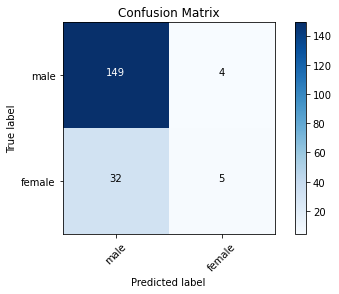

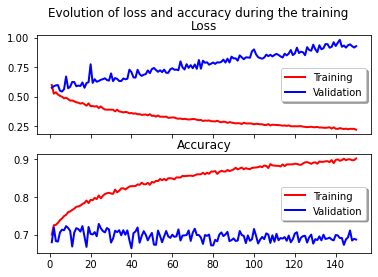

In [18]:
id='cnn_5_standardized_remSMOTE'
model = cnn_5()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 Standardization rem/SMOTE', 'cnn_5', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)